<a href="https://colab.research.google.com/github/rickyC3/GAN-image-generator/blob/main/%E3%80%8C%E3%80%8CAI_image_generator_V5_1_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC_(1)_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/scribbless/another-anime-face-dataset")

# rezortchen
# 40c0d3580d79cba8d01f6cf6a009adb9

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rezortchen
Your Kaggle Key: ··········


100%|██████████| 1.44G/1.44G [00:15<00:00, 98.6MB/s]


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf


In [ ]:
path = "/content/another-anime-face-dataset/animefaces256cleaner/"

# https://www.kaggle.com/code/swepat/cyclegan-to-generate-monet-style-images

In [ ]:
def show_img_info(path):
    d_img_size = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_img_size[image.shape] = d_img_size.get(image.shape, 0)+1
    
    for size, count in d_img_size.items():
        print(f'shape: {size}\tcount: {count}')
        
show_img_info(path)

shape: (256, 256, 3)	count: 92219


In [ ]:
def imgToNp(path):
    data_np = np.empty((3000, 64, 64, 3), dtype = np.int64)
    idx = 0
    for image_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.resize(img, (64, 64))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = np.array(img)
        data_np[idx] = img_array
        idx+=1
        if idx >= 3000:break
        
    return data_np

In [ ]:
data = imgToNp(path)

In [ ]:
data.shape

(3000, 64, 64, 3)

In [ ]:
print(type(data))

<class 'numpy.ndarray'>


In [ ]:
print(data[1].shape)

(64, 64, 3)


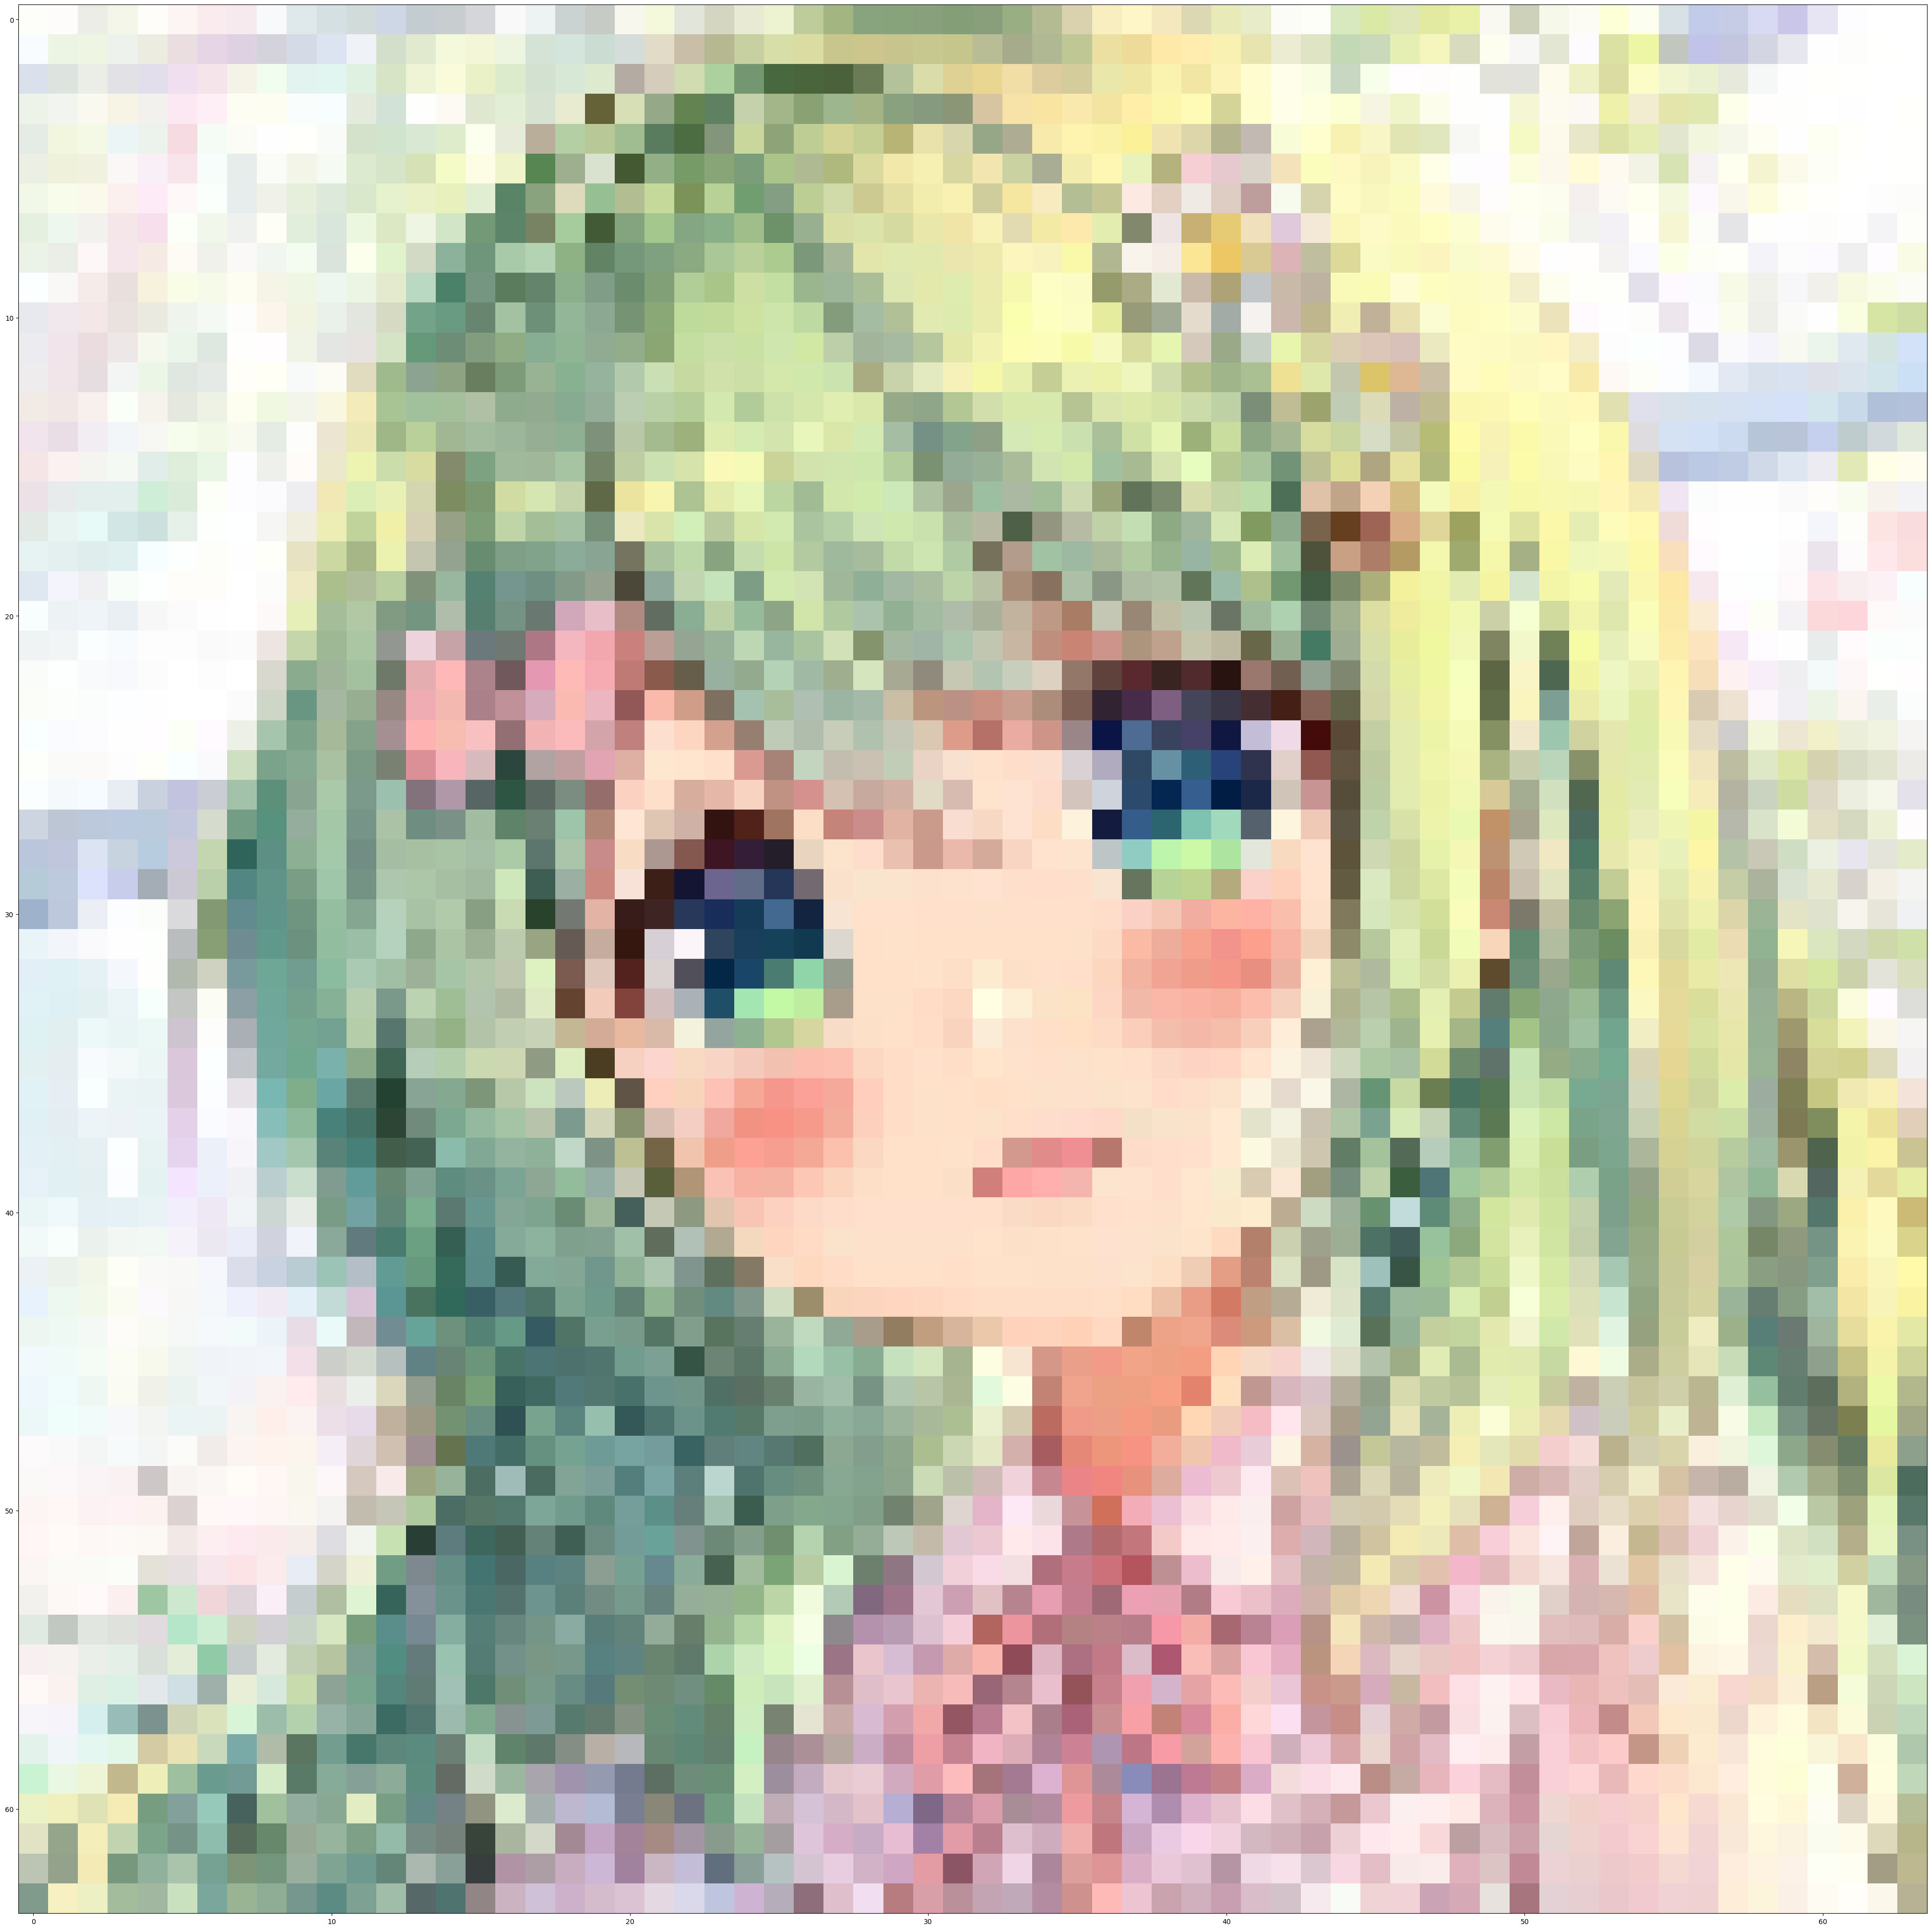

In [ ]:
image = data[400]

#plt.figure(figsize = (50, 50))
plt.imshow(image)
plt.show()

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Activation, LeakyReLU
from keras.optimizers import Adam
import numpy as np
import cv2
from keras.layers import UpSampling2D, Dropout, MaxPooling2D
#from tensorflow.compat.v1.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow import keras

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.1 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from keras.engine.sequential import model_serialization
class GAN():

  def __init__(self, data):
    self.generator = self.build_generator()
    self.discriminator = self.build_discriminator()
    optimizer = Adam(0.0002, 0.5)


    self.generator.compile(optimizer = optimizer, loss = "binary_crossentropy")
    self.discriminator.compile(optimizer =optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
    
    
    self.data = data
    

    self.gan = Sequential()
    self.gan.add(self.generator)
    self.gan.add(self.discriminator)
    self.discriminator.trainable = False
    self.gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))
    self.gan.summary()


  def build_generator(self):

    noise_shape = (100,)

    model = Sequential()

    # noise to 4*4*3
    model.add(Dense(4 * 4 * 512, input_shape=noise_shape, activation = "linear"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 512)))

    # upsample the img
    model.add(Conv2DTranspose(256, kernel_size=[4, 4], strides=[2,2], padding="same",kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    # 8, 8, 512
    model.add(tfa.layers.InstanceNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, kernel_size=[4, 4], strides=[2,2], padding="same",kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    # 16, 16, 256
    model.add(tfa.layers.InstanceNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, kernel_size=[4, 4], strides=[2,2], padding="same",kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    # 32, 32, 128
    model.add(tfa.layers.InstanceNormalization())  
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(32, kernel_size=[4, 4], strides=[2,2], padding="same",kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    # 64, 64, 64
    model.add(tfa.layers.InstanceNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # optupt 64*64*3
    model.add(Conv2DTranspose(3, kernel_size=[4, 4], strides=[1,1], padding="same",activation = "tanh",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    
    model.summary()

    """noise = Input(shape=noise_shape)
    img = model(noise)

    generator_model = Model(inputs=noise, outputs=img)"""

    return model

  def build_discriminator(self):
    img_shape = (64, 64, 3)
    
    model = Sequential()

    model.add(Conv2D(256, kernel_size=3, strides=1, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(tfa.layers.InstanceNormalization())
    
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(tfa.layers.InstanceNormalization())
    

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(tfa.layers.InstanceNormalization())
    

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))
    

    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    """
    img = Input(shape=img_shape)
    validity = model(img)

    discriminator_model = Model(inputs=img, outputs=validity)"""

    return model
  

    


  def train(self, epochs, batchsize):
    
    self.data = (self.data.astype(np.float32) - 127.5) / 127.5
    mean_dloss = [0, 0]
    mean_gloss = 0
    for epoch in range(epochs):
      
      idx = np.random.randint(0, self.data.shape[0], batchsize)
      real_imgs = self.data[idx]

      noise = np.random.normal(0, 1, (batchsize, 100))
      generated_imgs = self.generator.predict(noise)


      d_loss_real = self.discriminator.train_on_batch(real_imgs, np.ones((batchsize, 1)))
      d_loss_fake = self.discriminator.train_on_batch(generated_imgs, np.zeros((batchsize, 1)))
      d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
      mean_dloss[0] += d_loss[0]
      mean_dloss[1] += d_loss[1]
      
      for i in range(2):
        valid_y = np.array([1] * batchsize)
        noise = np.random.normal(0, 1, (batchsize, 100))
        g_loss = self.gan.train_on_batch(noise, valid_y)
        
      mean_gloss += g_loss

      if epoch%100 == 0:
        noise2 = np.random.normal(0, 1, (1, 100))
        val = self.gan.predict(noise2)
        print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f], [val: %f]" % (epoch, mean_dloss[0]/100, 100*mean_dloss[1]/100, mean_gloss/100, val))
        mean_dloss = [0, 0]
        mean_gloss = 0
      if epoch%500 == 0:
        self.show_img(epoch)

    return 0
    
  def show_img(self, epoch):

    for i in range(5):
      noise = np.random.normal(0, 1, (1,100))
      img = self.generator.predict(noise)
      img = (img+1)*127.5
      img = img.astype(np.int64)
      #img = 0.5 * img + 0.5
      plt.figure(figsize = (8,8))
      plt.imshow(img[0])
      plt.savefig('history/my_plot%d-%d.png'% (epoch, i))
      plt.show()
    return 0  


    

In [ ]:
!mkdir history

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8192)              827392    
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_6 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 8, 8, 256)        2097408   
 Transpose)                                                      
                                                                 
 instance_normalization_23 (  (None, 8, 8, 256)        512       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 8, 8, 256)       

4/4 [==============================] - 0s 11ms/step


1/1 [==============================] - 1s 590ms/step
0 [Discriminator loss: 0.016054, acc.: 0.18%] [Generator loss: 0.008614], [val: 0.401142]
1/1 [==============================] - 0s 291ms/step


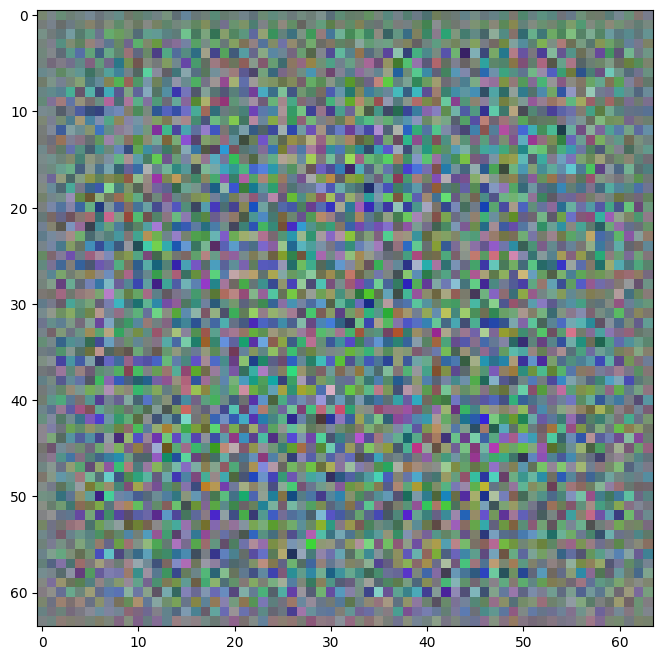

1/1 [==============================] - 0s 29ms/step


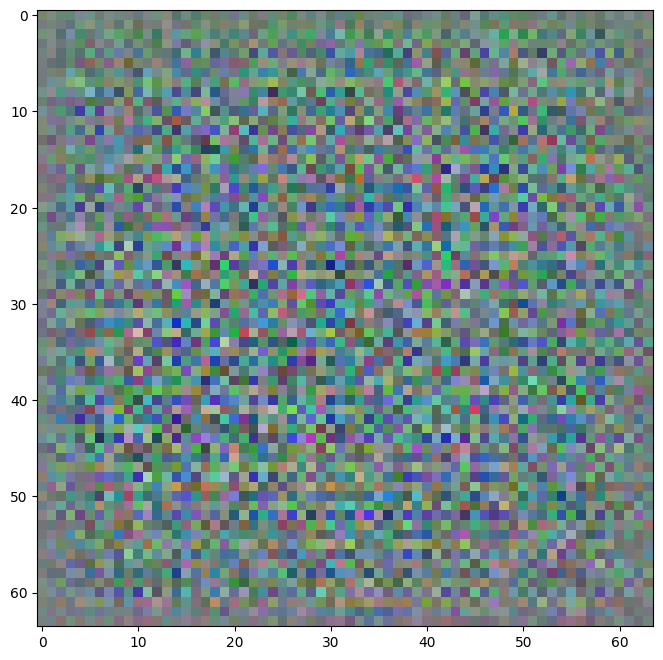

1/1 [==============================] - 0s 23ms/step


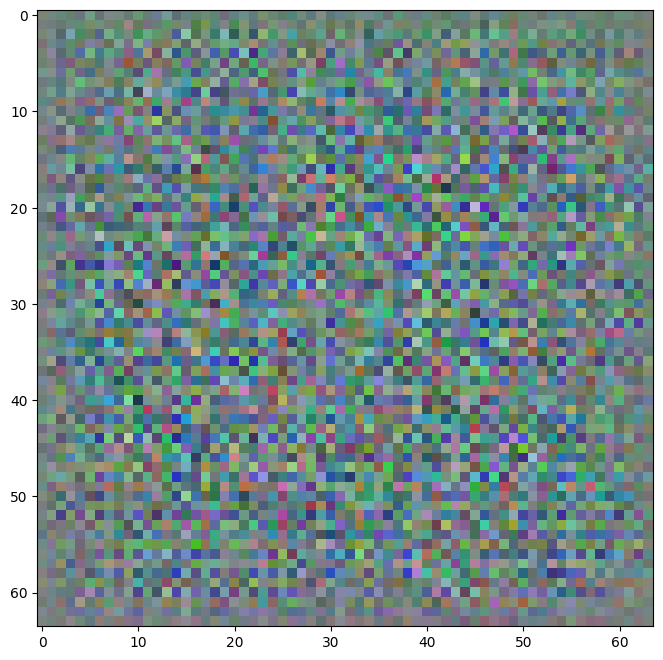

1/1 [==============================] - 0s 25ms/step


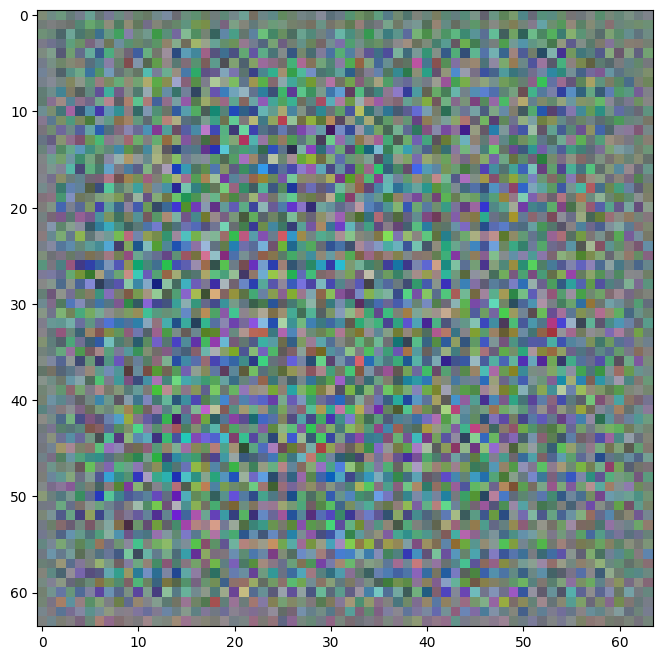

1/1 [==============================] - 0s 34ms/step


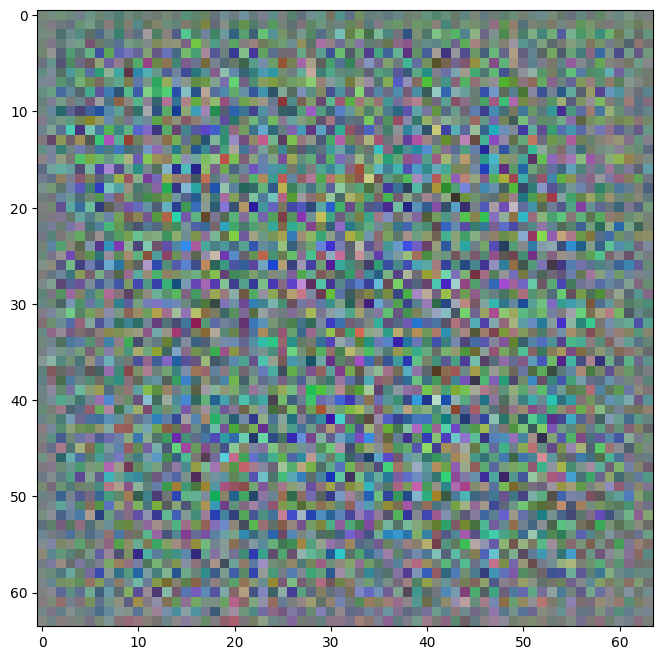

1/1 [==============================] - 0s 32ms/step
100 [Discriminator loss: 0.330891, acc.: 86.10%] [Generator loss: 3.866646], [val: 0.018207]
1/1 [==============================] - 0s 21ms/step
200 [Discriminator loss: 0.393201, acc.: 82.65%] [Generator loss: 3.236512], [val: 0.008027]
1/1 [==============================] - 0s 23ms/step
300 [Discriminator loss: 0.354210, acc.: 84.75%] [Generator loss: 3.178687], [val: 0.114071]
1/1 [==============================] - 0s 25ms/step
400 [Discriminator loss: 0.390395, acc.: 82.96%] [Generator loss: 2.881315], [val: 0.108979]
1/1 [==============================] - 0s 35ms/step
500 [Discriminator loss: 0.318219, acc.: 87.02%] [Generator loss: 3.197888], [val: 0.369791]
1/1 [==============================] - 0s 23ms/step


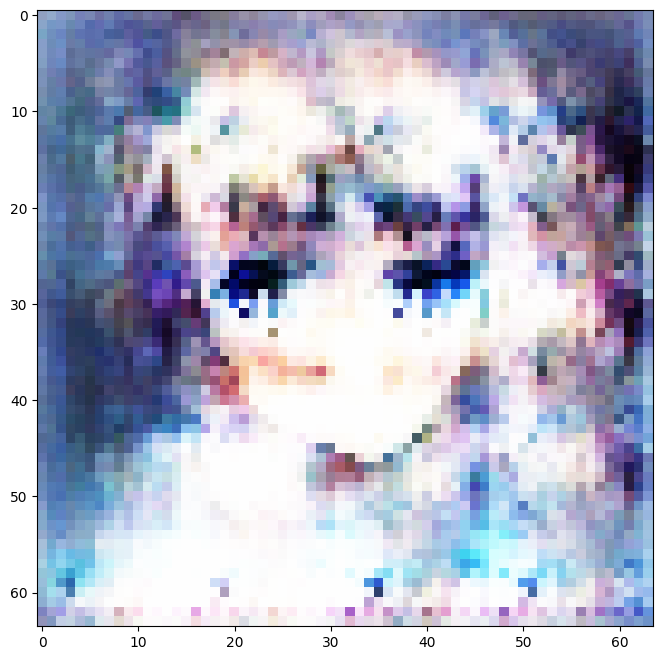

1/1 [==============================] - 0s 24ms/step


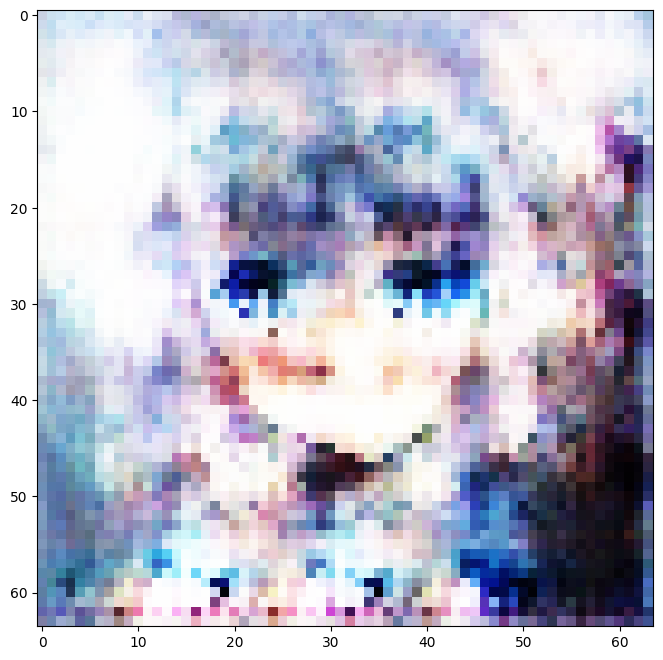

1/1 [==============================] - 0s 22ms/step


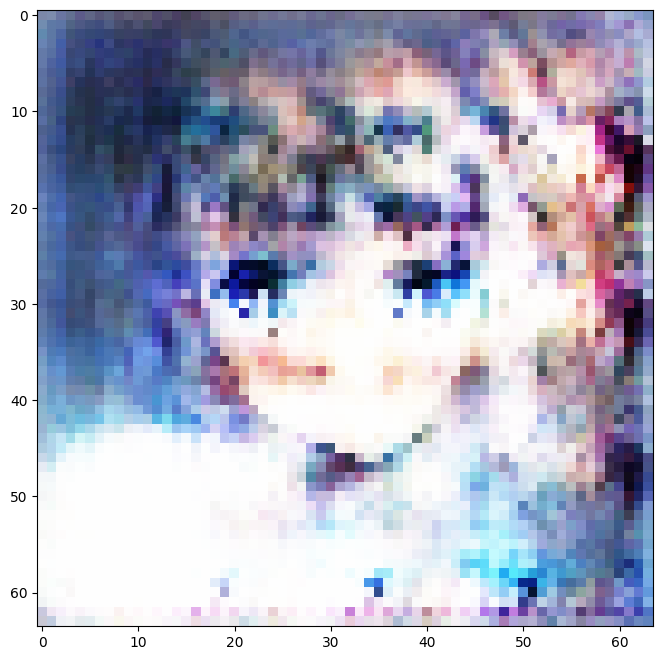

1/1 [==============================] - 0s 22ms/step


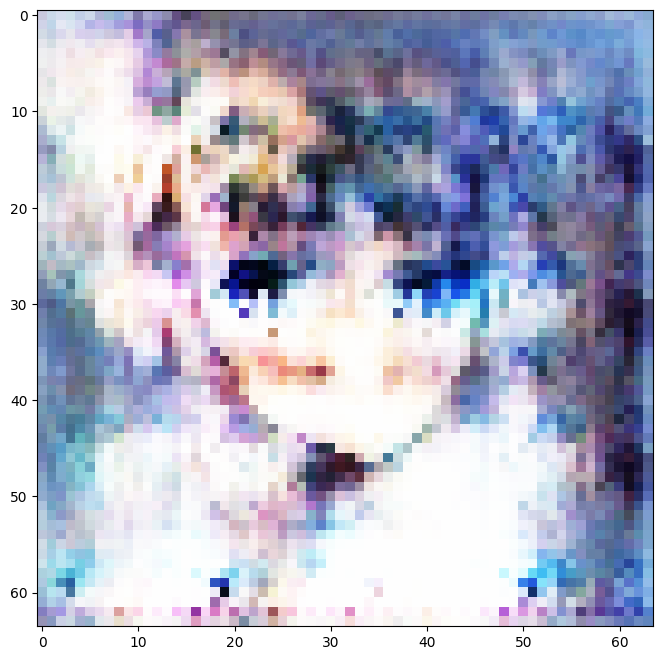

1/1 [==============================] - 0s 22ms/step


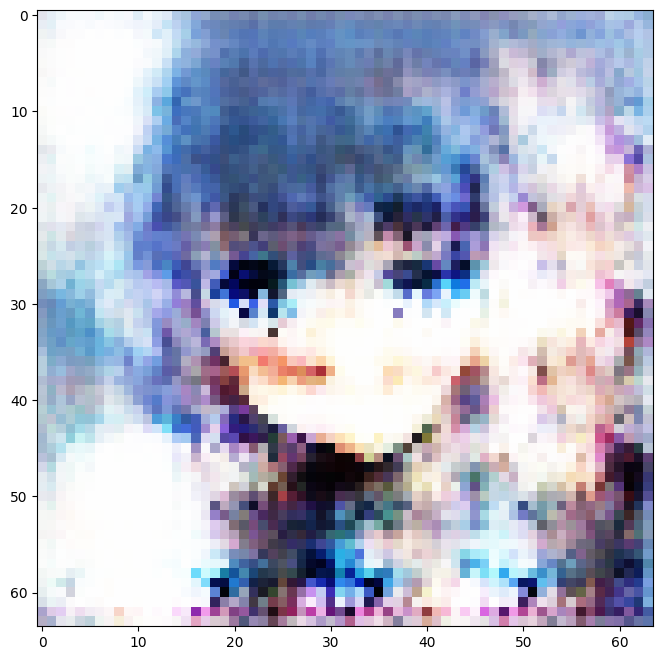

1/1 [==============================] - 0s 24ms/step
600 [Discriminator loss: 0.412962, acc.: 81.51%] [Generator loss: 2.615897], [val: 0.129620]
1/1 [==============================] - 0s 26ms/step
700 [Discriminator loss: 0.356340, acc.: 84.22%] [Generator loss: 3.052339], [val: 0.017555]
1/1 [==============================] - 0s 24ms/step
800 [Discriminator loss: 0.329025, acc.: 85.55%] [Generator loss: 3.026784], [val: 0.223007]
1/1 [==============================] - 0s 27ms/step
900 [Discriminator loss: 0.330614, acc.: 85.65%] [Generator loss: 3.231523], [val: 0.109905]
1/1 [==============================] - 0s 38ms/step
1000 [Discriminator loss: 0.317856, acc.: 86.23%] [Generator loss: 3.155068], [val: 0.073904]
1/1 [==============================] - 0s 40ms/step


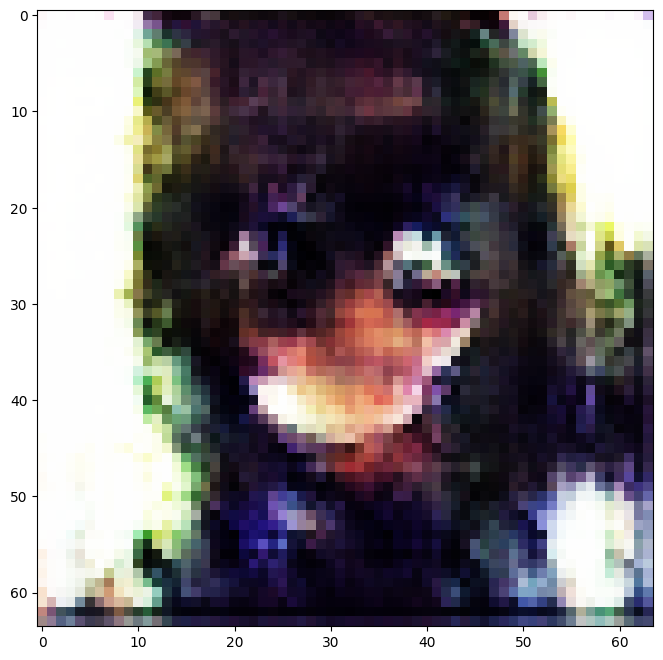

1/1 [==============================] - 0s 40ms/step


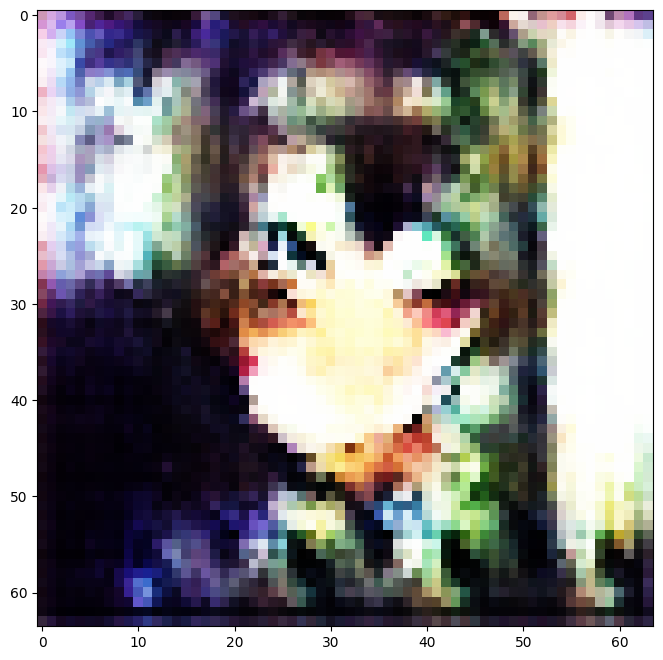

1/1 [==============================] - 0s 23ms/step


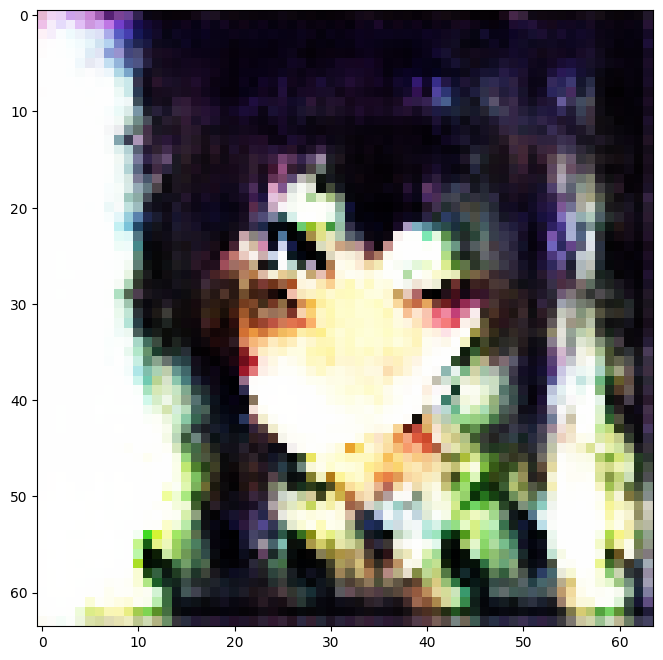

1/1 [==============================] - 0s 24ms/step


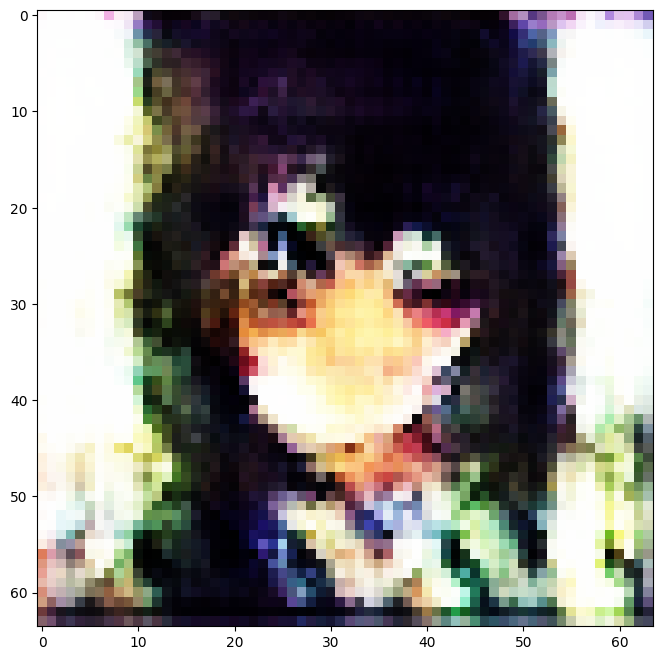

1/1 [==============================] - 0s 25ms/step


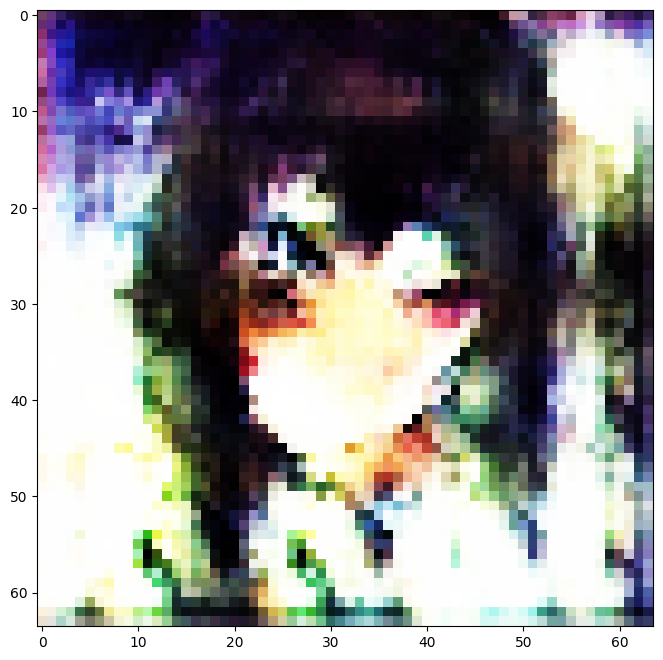

1/1 [==============================] - 0s 25ms/step
1100 [Discriminator loss: 0.346745, acc.: 85.71%] [Generator loss: 2.892514], [val: 0.300753]
1/1 [==============================] - 0s 46ms/step
1200 [Discriminator loss: 0.340227, acc.: 85.77%] [Generator loss: 2.941710], [val: 0.209040]
1/1 [==============================] - 0s 38ms/step
1300 [Discriminator loss: 0.295096, acc.: 87.82%] [Generator loss: 3.238799], [val: 0.023553]
1/1 [==============================] - 0s 23ms/step
1400 [Discriminator loss: 0.259050, acc.: 89.29%] [Generator loss: 3.301279], [val: 0.517065]
1/1 [==============================] - 0s 25ms/step
1500 [Discriminator loss: 0.338955, acc.: 85.27%] [Generator loss: 3.148375], [val: 0.259664]
1/1 [==============================] - 0s 23ms/step


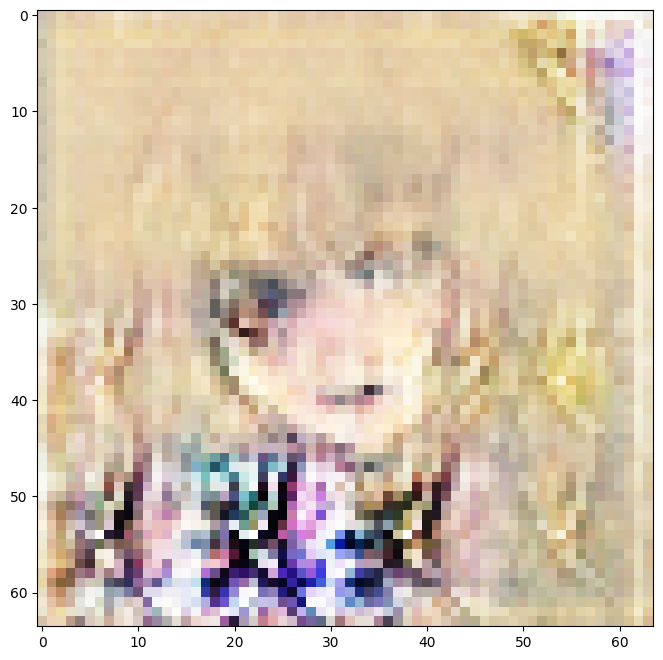

1/1 [==============================] - 0s 23ms/step


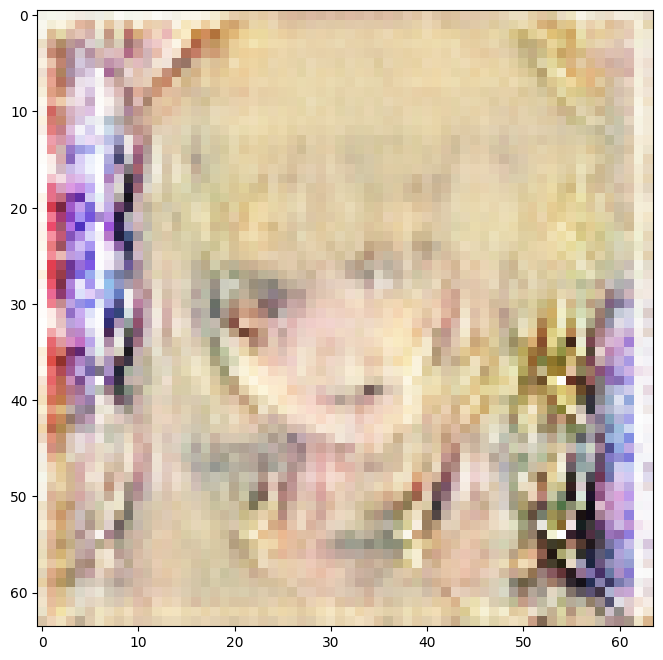

1/1 [==============================] - 0s 22ms/step


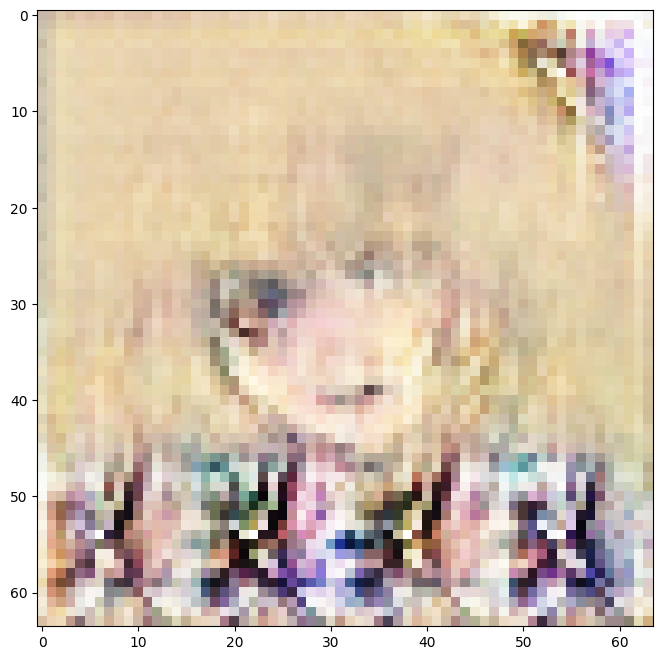

1/1 [==============================] - 0s 24ms/step


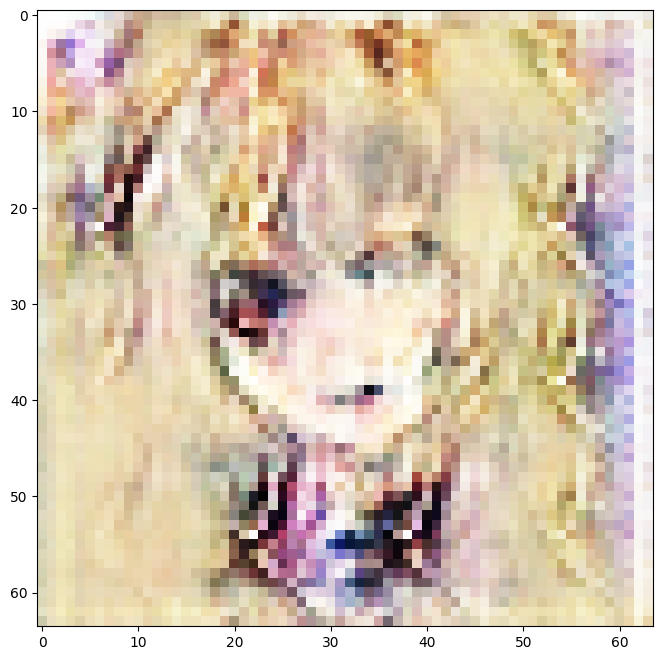

1/1 [==============================] - 0s 30ms/step


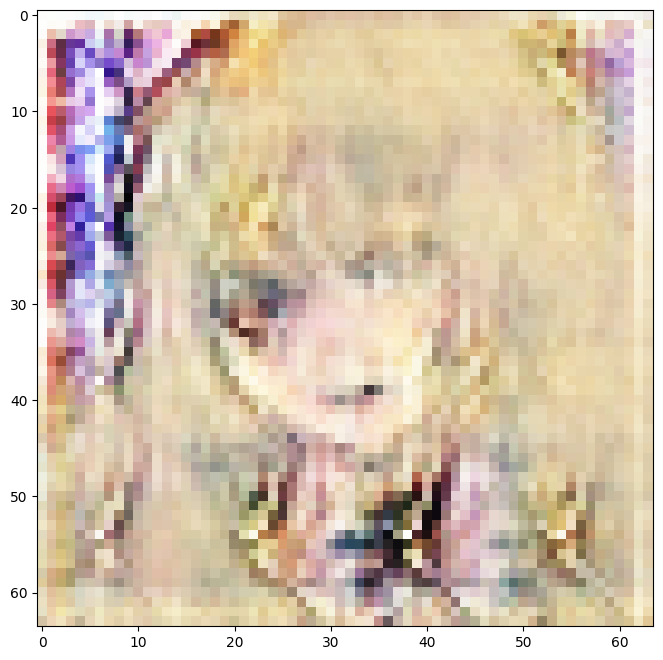

1/1 [==============================] - 0s 32ms/step
1600 [Discriminator loss: 0.323792, acc.: 86.44%] [Generator loss: 3.075934], [val: 0.104342]
1/1 [==============================] - 0s 26ms/step
1700 [Discriminator loss: 0.284713, acc.: 88.23%] [Generator loss: 3.104586], [val: 0.239641]
1/1 [==============================] - 0s 22ms/step
1800 [Discriminator loss: 0.347421, acc.: 86.02%] [Generator loss: 2.821567], [val: 0.099354]
1/1 [==============================] - 0s 29ms/step
1900 [Discriminator loss: 0.312905, acc.: 86.36%] [Generator loss: 3.182828], [val: 0.161556]
1/1 [==============================] - 0s 24ms/step
2000 [Discriminator loss: 0.265886, acc.: 89.00%] [Generator loss: 3.207459], [val: 0.031615]
1/1 [==============================] - 0s 22ms/step


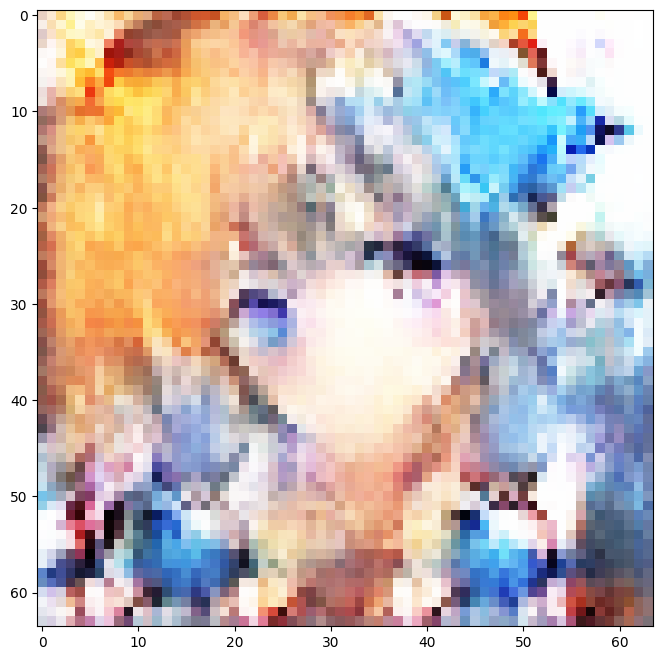

1/1 [==============================] - 0s 26ms/step


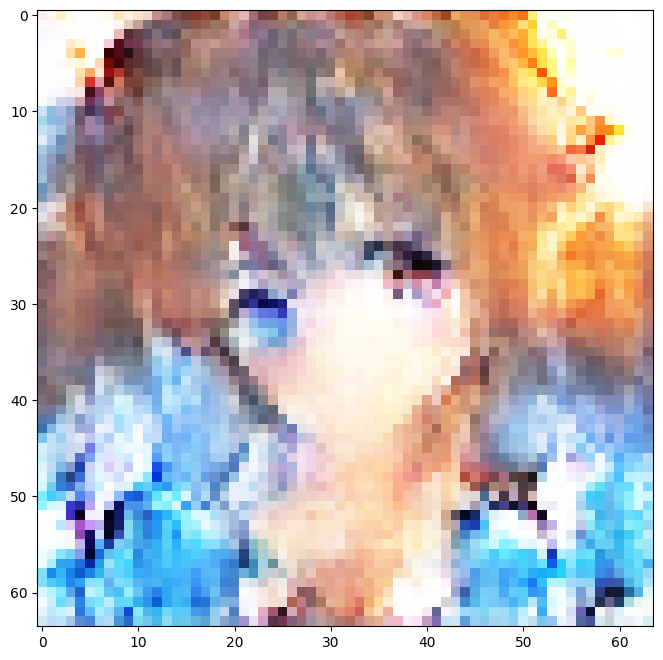

1/1 [==============================] - 0s 24ms/step


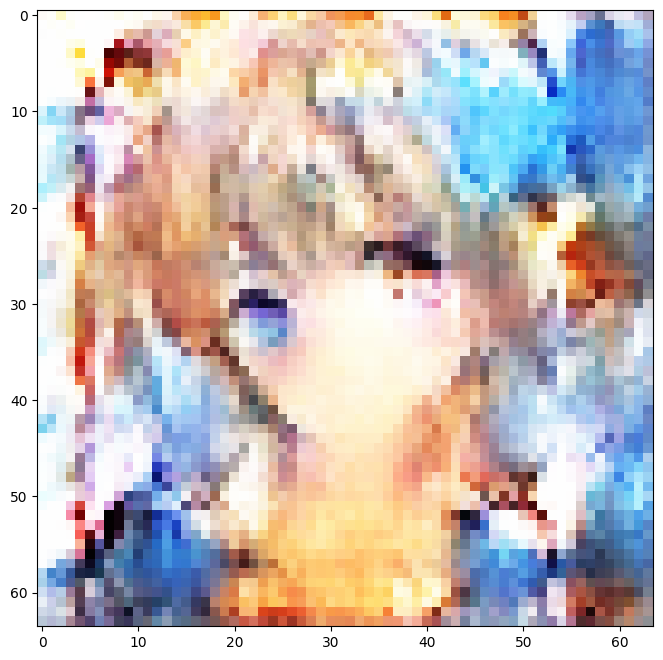

1/1 [==============================] - 0s 22ms/step


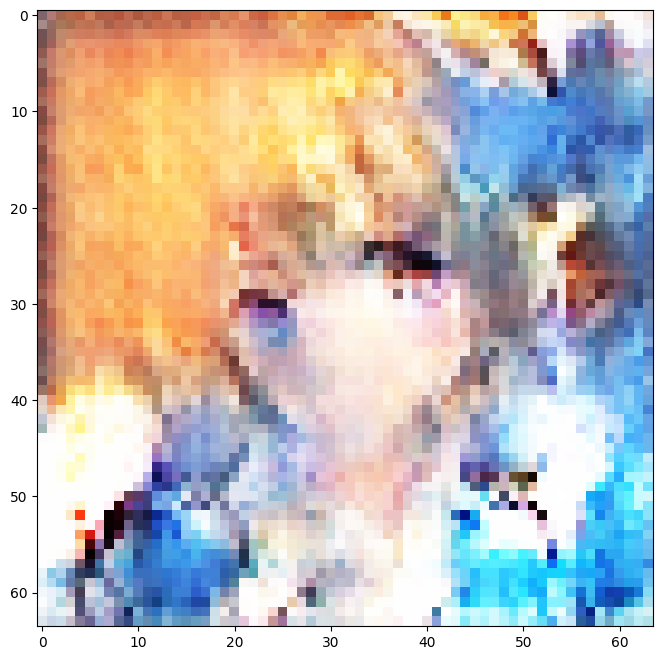

1/1 [==============================] - 0s 23ms/step


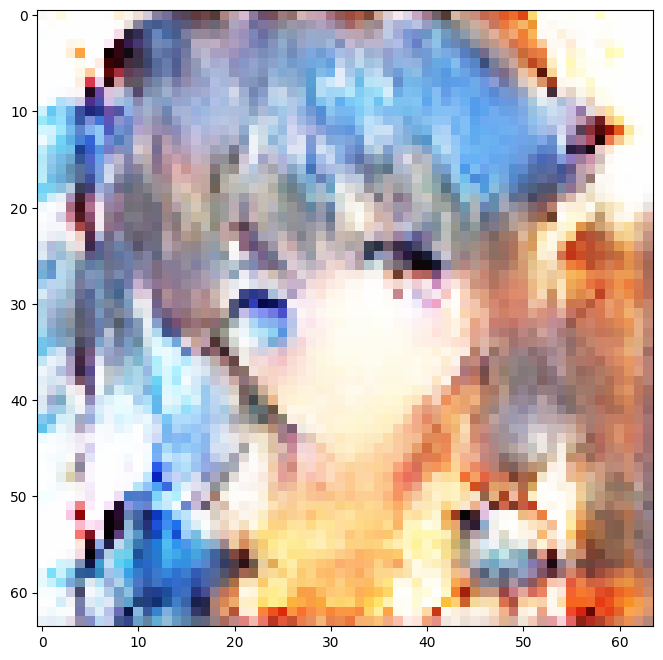

1/1 [==============================] - 0s 22ms/step
2100 [Discriminator loss: 0.322478, acc.: 86.75%] [Generator loss: 2.891930], [val: 0.052992]
1/1 [==============================] - 0s 20ms/step
2200 [Discriminator loss: 0.383840, acc.: 83.91%] [Generator loss: 2.508170], [val: 0.083343]
1/1 [==============================] - 0s 20ms/step
2300 [Discriminator loss: 0.324737, acc.: 86.23%] [Generator loss: 2.938397], [val: 0.088183]
1/1 [==============================] - 0s 20ms/step
2400 [Discriminator loss: 0.313246, acc.: 86.30%] [Generator loss: 2.920527], [val: 0.091842]
1/1 [==============================] - 0s 35ms/step
2500 [Discriminator loss: 0.409195, acc.: 82.16%] [Generator loss: 2.518109], [val: 0.229958]
1/1 [==============================] - 0s 33ms/step


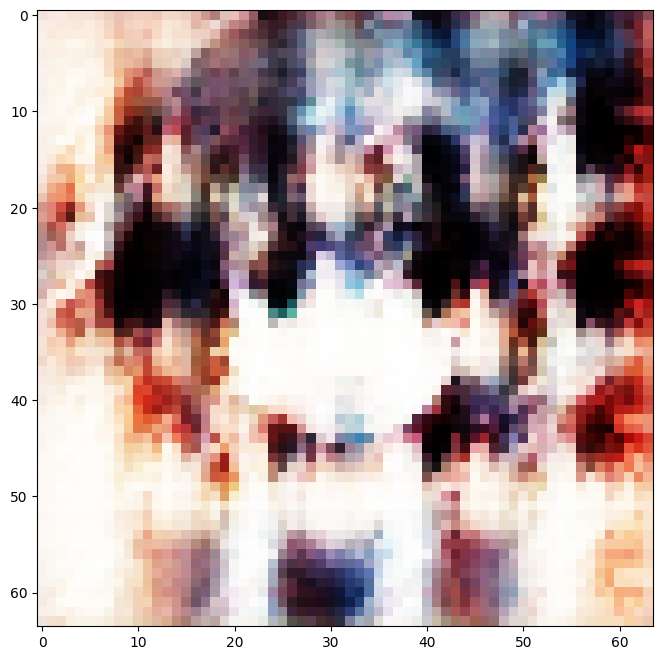

1/1 [==============================] - 0s 28ms/step


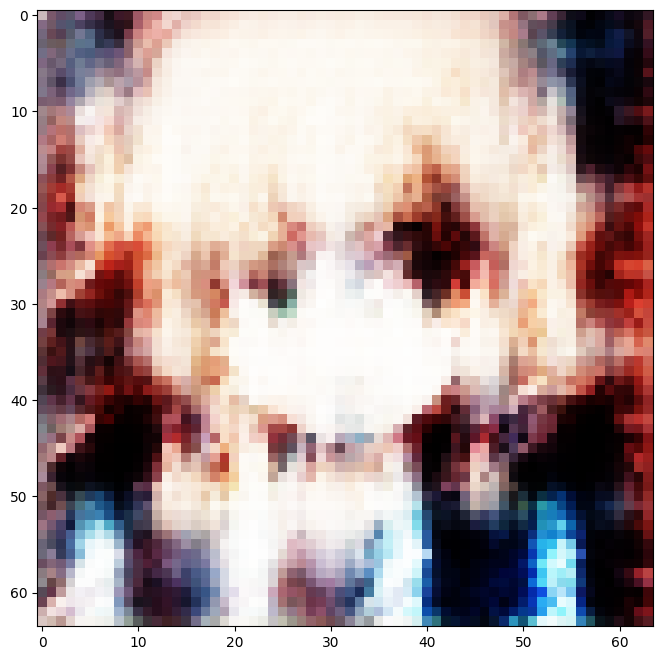

1/1 [==============================] - 0s 33ms/step


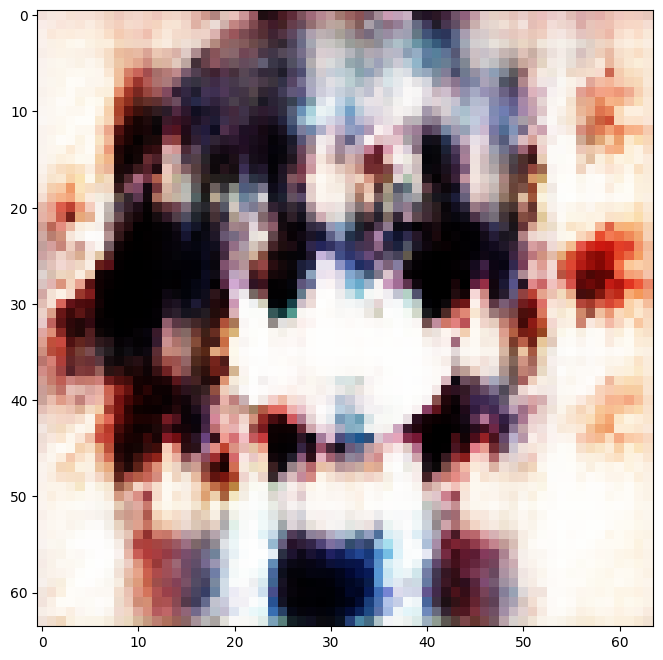

1/1 [==============================] - 0s 20ms/step


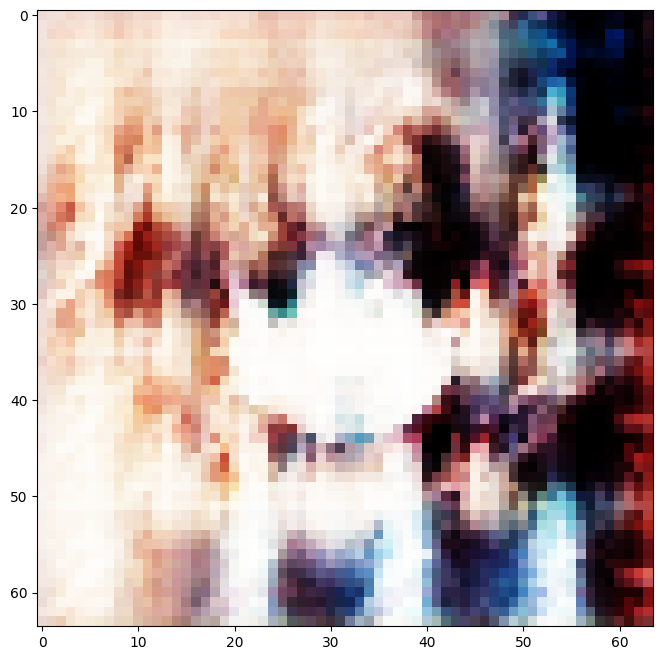

1/1 [==============================] - 0s 21ms/step


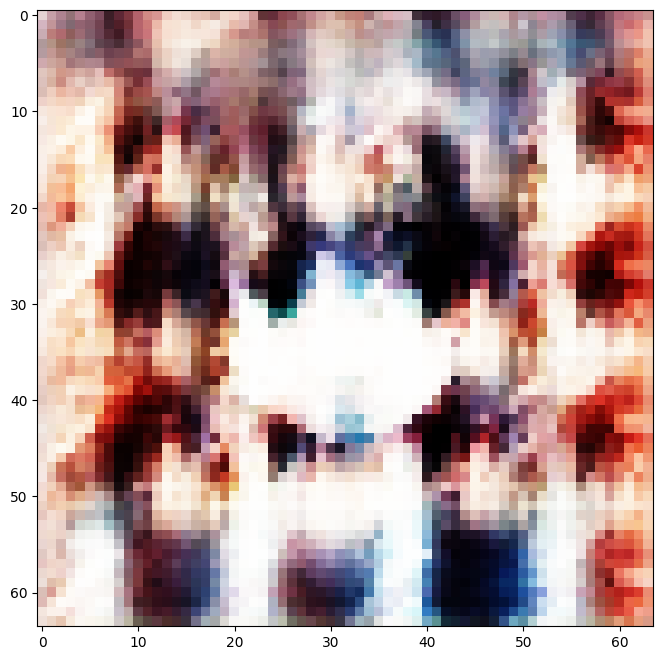

1/1 [==============================] - 0s 19ms/step
2600 [Discriminator loss: 0.321586, acc.: 87.15%] [Generator loss: 2.724423], [val: 0.133242]
1/1 [==============================] - 0s 21ms/step
2700 [Discriminator loss: 0.263013, acc.: 89.80%] [Generator loss: 3.092514], [val: 0.200438]
1/1 [==============================] - 0s 29ms/step
2800 [Discriminator loss: 0.332983, acc.: 85.73%] [Generator loss: 2.610152], [val: 0.083591]
1/1 [==============================] - 0s 32ms/step
2900 [Discriminator loss: 0.329725, acc.: 86.02%] [Generator loss: 2.578156], [val: 0.128024]
1/1 [==============================] - 0s 23ms/step
3000 [Discriminator loss: 0.325955, acc.: 86.25%] [Generator loss: 2.589128], [val: 0.059388]
1/1 [==============================] - 0s 19ms/step


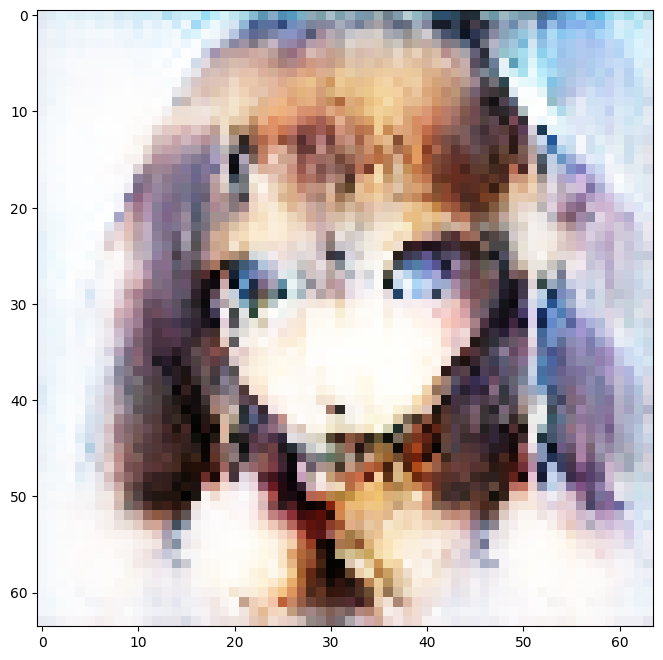

1/1 [==============================] - 0s 23ms/step


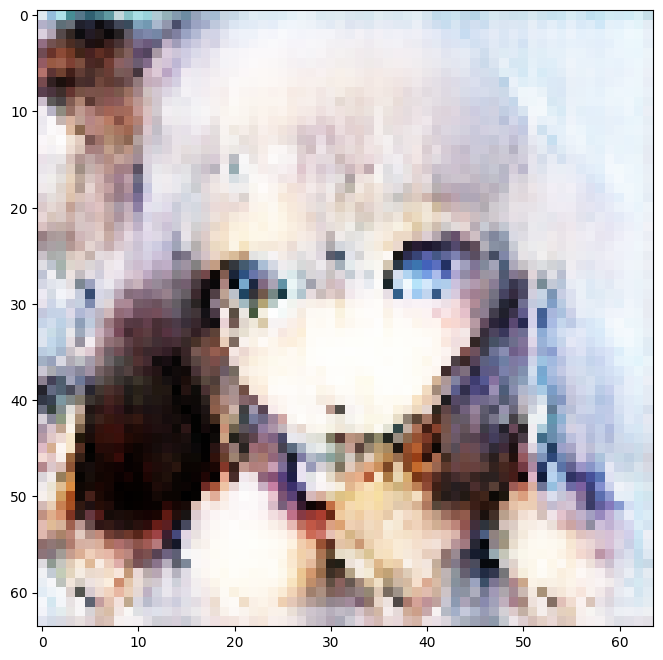

1/1 [==============================] - 0s 23ms/step


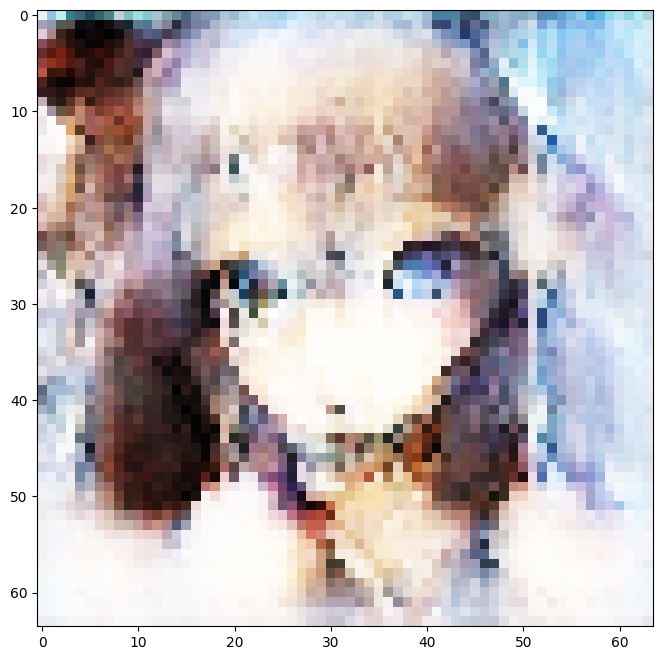

1/1 [==============================] - 0s 21ms/step


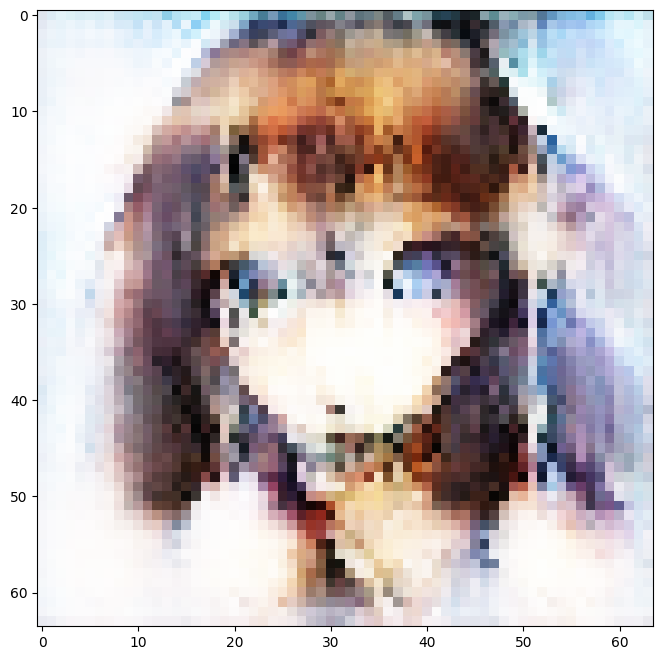

1/1 [==============================] - 0s 21ms/step


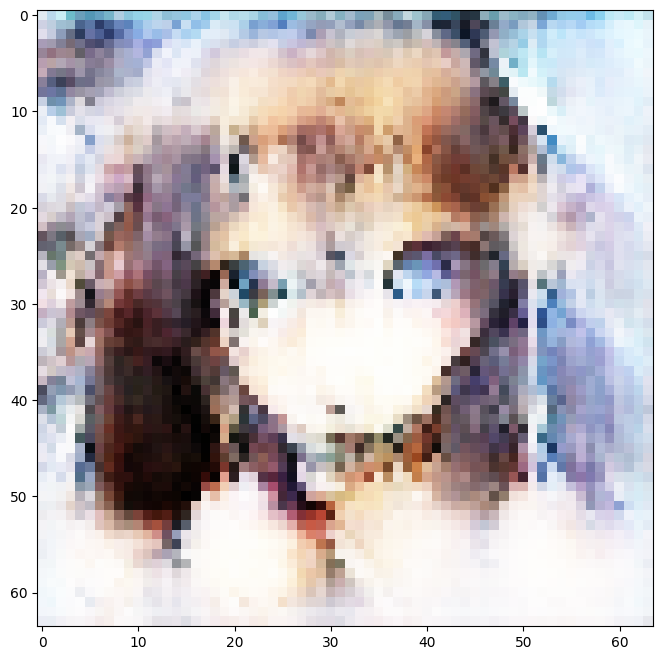

1/1 [==============================] - 0s 19ms/step
3100 [Discriminator loss: 0.295628, acc.: 88.36%] [Generator loss: 2.805793], [val: 0.030060]
1/1 [==============================] - 0s 19ms/step
3200 [Discriminator loss: 0.303370, acc.: 87.30%] [Generator loss: 2.833006], [val: 0.070328]
1/1 [==============================] - 0s 31ms/step
3300 [Discriminator loss: 0.336329, acc.: 86.27%] [Generator loss: 2.754614], [val: 0.033629]
1/1 [==============================] - 0s 20ms/step
3400 [Discriminator loss: 0.312339, acc.: 87.59%] [Generator loss: 2.676545], [val: 0.086202]
1/1 [==============================] - 0s 21ms/step
3500 [Discriminator loss: 0.321436, acc.: 87.08%] [Generator loss: 2.647360], [val: 0.029951]
1/1 [==============================] - 0s 32ms/step


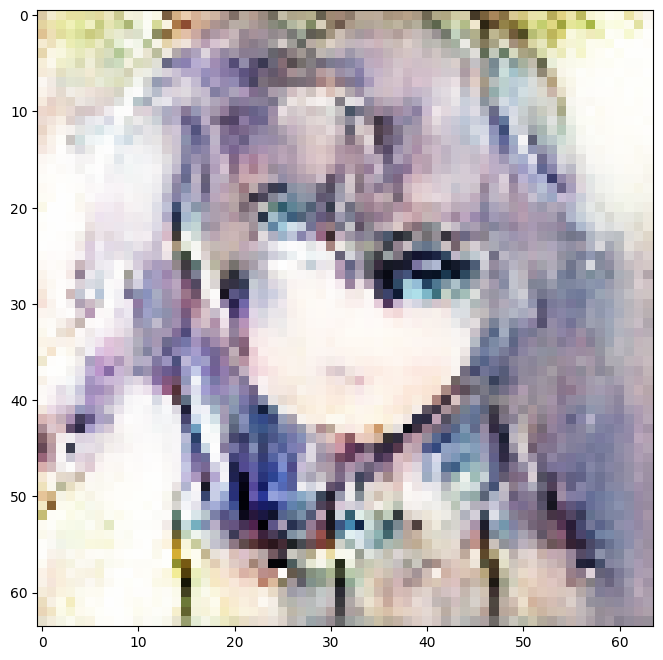

1/1 [==============================] - 0s 25ms/step


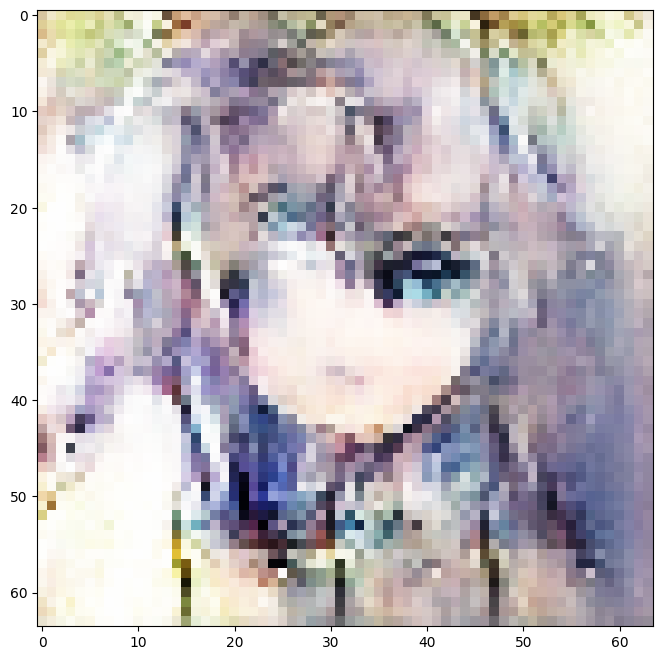

1/1 [==============================] - 0s 19ms/step


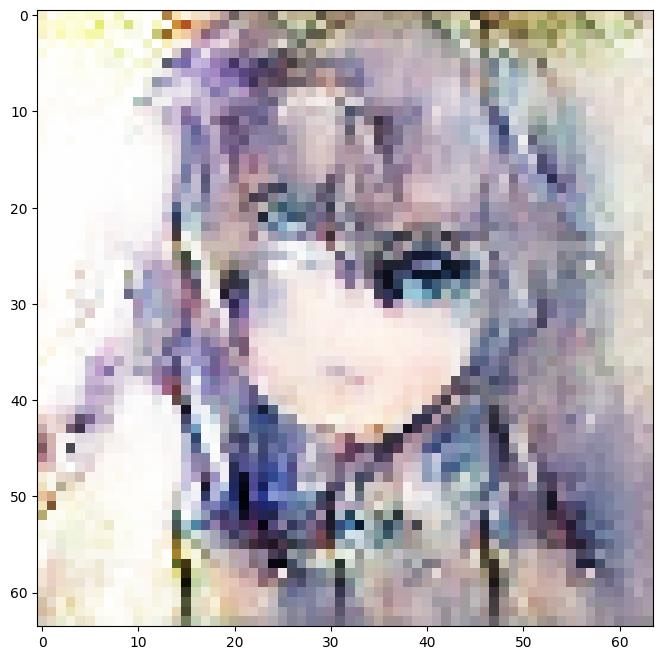

1/1 [==============================] - 0s 19ms/step


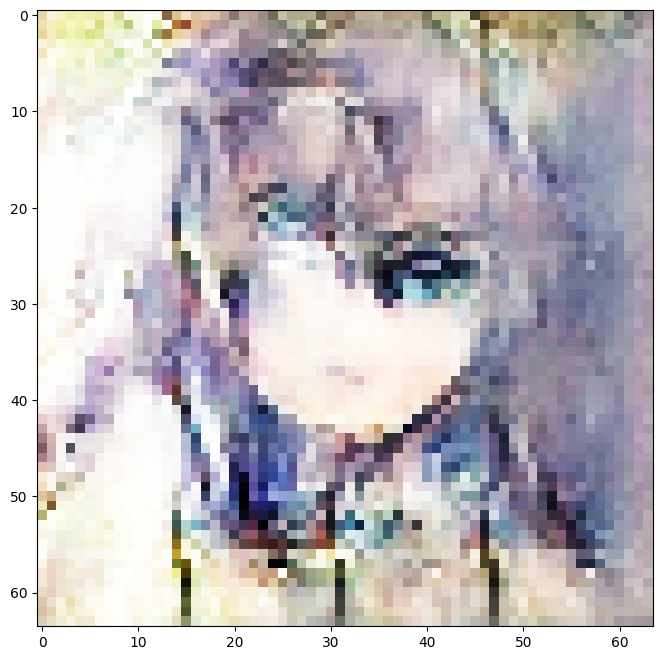

1/1 [==============================] - 0s 21ms/step


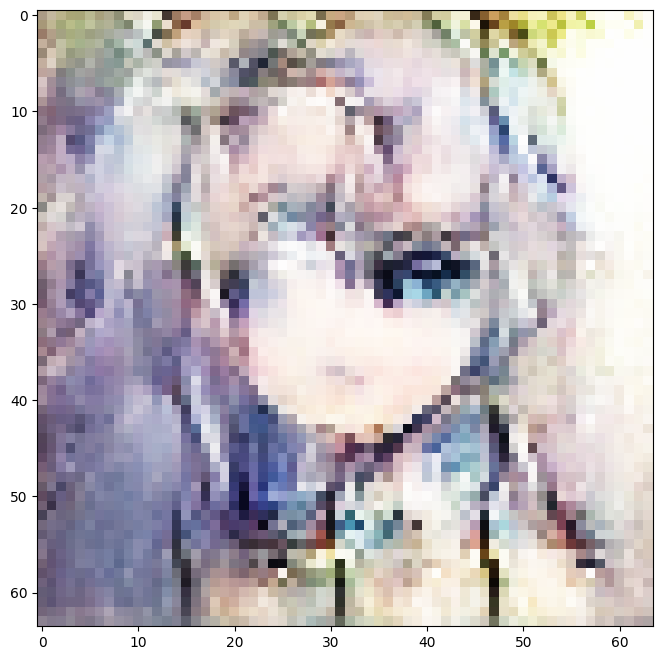

1/1 [==============================] - 0s 21ms/step
3600 [Discriminator loss: 0.270927, acc.: 88.84%] [Generator loss: 3.002964], [val: 0.038040]
1/1 [==============================] - 0s 32ms/step
3700 [Discriminator loss: 0.322244, acc.: 86.99%] [Generator loss: 2.598574], [val: 0.076014]
1/1 [==============================] - 0s 20ms/step
3800 [Discriminator loss: 0.304532, acc.: 86.75%] [Generator loss: 2.868389], [val: 0.083221]
1/1 [==============================] - 0s 23ms/step
3900 [Discriminator loss: 0.308923, acc.: 87.76%] [Generator loss: 3.016249], [val: 0.075398]
1/1 [==============================] - 0s 25ms/step
4000 [Discriminator loss: 0.324564, acc.: 87.08%] [Generator loss: 2.346174], [val: 0.083089]
1/1 [==============================] - 0s 29ms/step


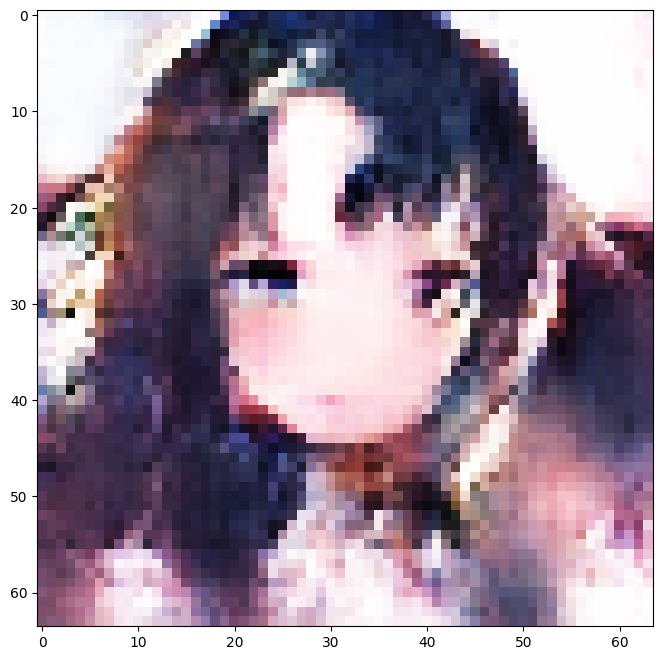

1/1 [==============================] - 0s 45ms/step


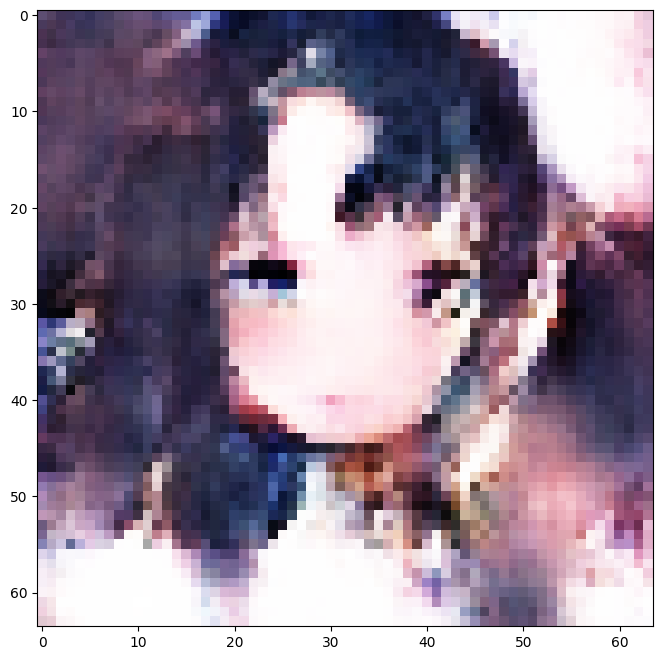

1/1 [==============================] - 0s 49ms/step


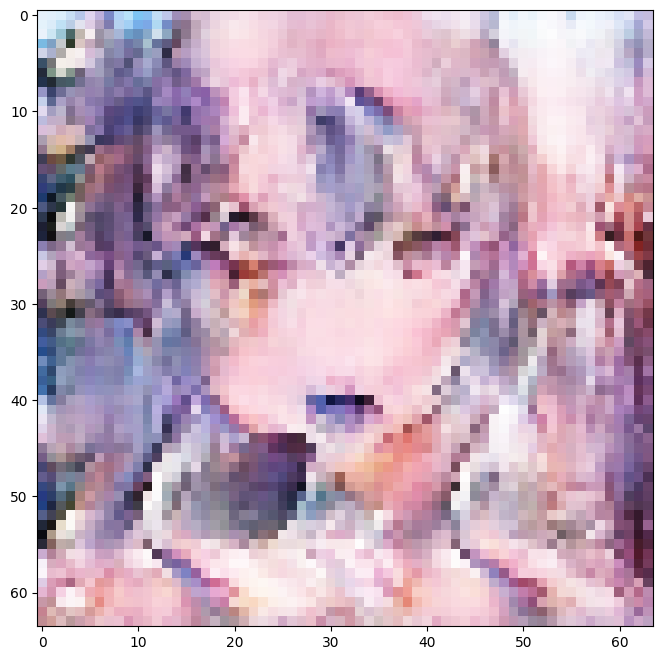

1/1 [==============================] - 0s 34ms/step


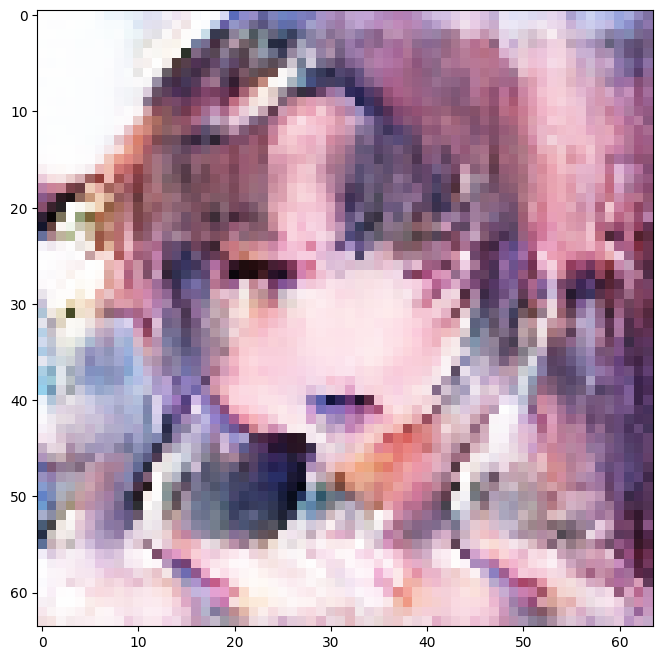

1/1 [==============================] - 0s 36ms/step


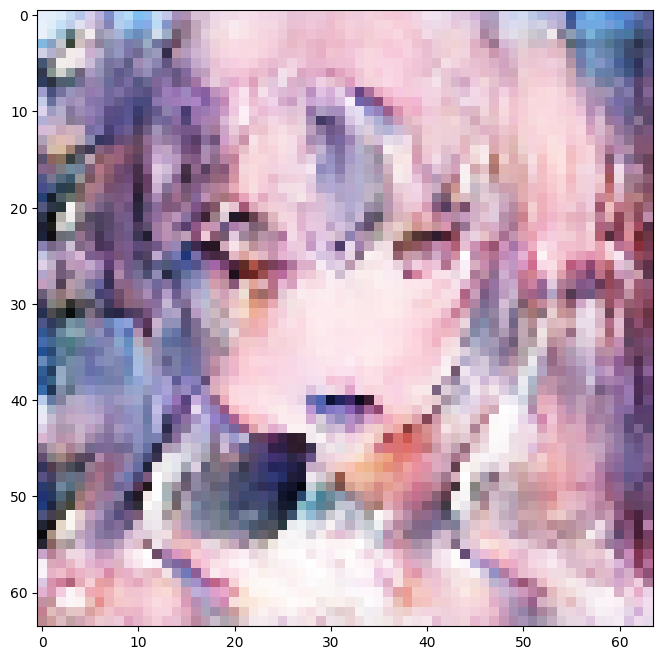

1/1 [==============================] - 0s 23ms/step
4100 [Discriminator loss: 0.291359, acc.: 88.05%] [Generator loss: 2.753369], [val: 0.191707]
1/1 [==============================] - 0s 26ms/step
4200 [Discriminator loss: 0.285632, acc.: 88.13%] [Generator loss: 2.841769], [val: 0.046364]
1/1 [==============================] - 0s 20ms/step
4300 [Discriminator loss: 0.332522, acc.: 86.56%] [Generator loss: 2.439618], [val: 0.098989]
1/1 [==============================] - 0s 32ms/step
4400 [Discriminator loss: 0.318699, acc.: 86.89%] [Generator loss: 2.588433], [val: 0.040216]
1/1 [==============================] - 0s 23ms/step
4500 [Discriminator loss: 0.305189, acc.: 87.34%] [Generator loss: 2.637911], [val: 0.153337]
1/1 [==============================] - 0s 23ms/step


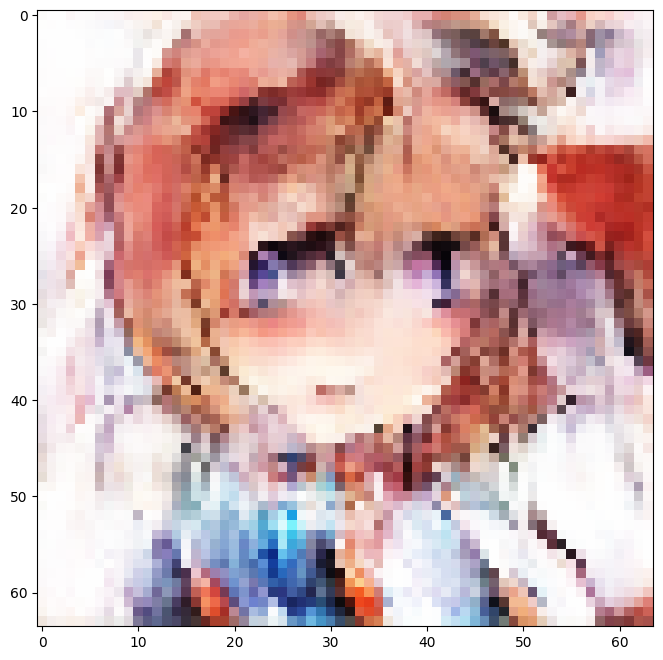

1/1 [==============================] - 0s 19ms/step


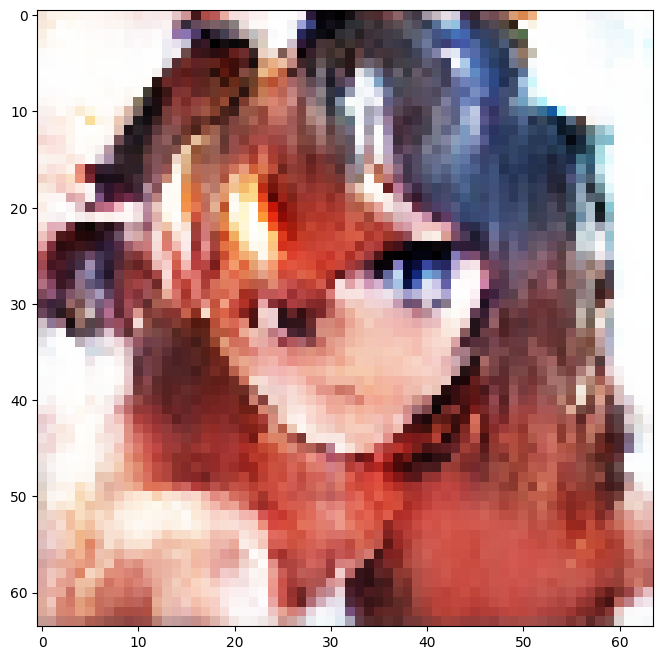

1/1 [==============================] - 0s 19ms/step


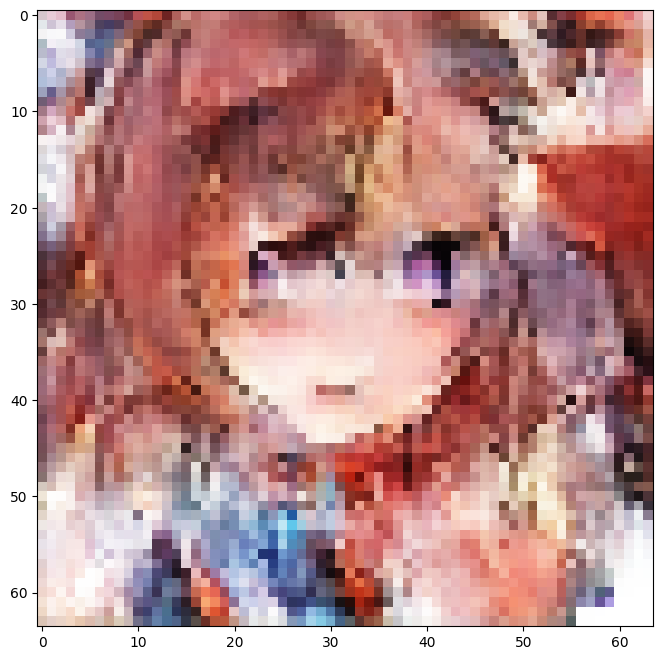

1/1 [==============================] - 0s 19ms/step


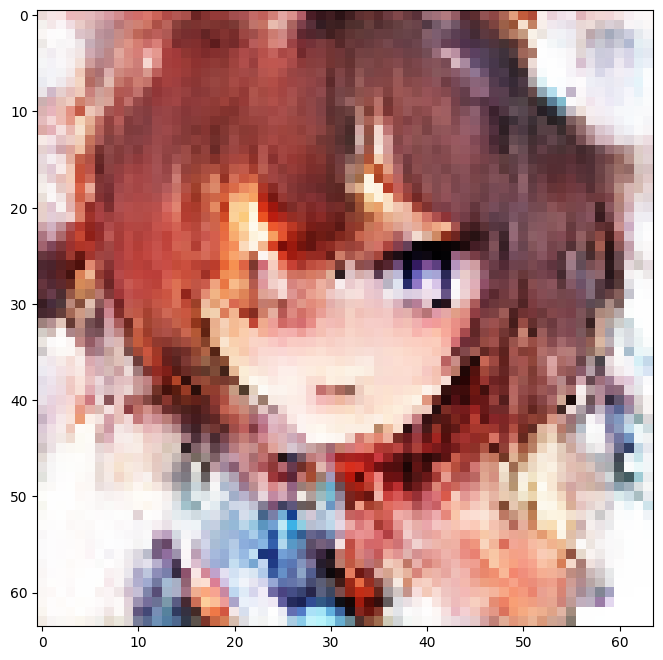

1/1 [==============================] - 0s 19ms/step


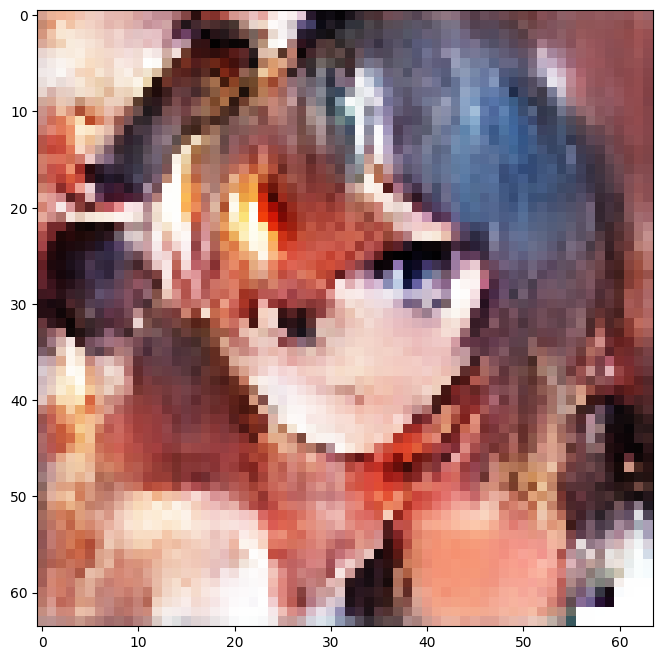

1/1 [==============================] - 0s 22ms/step
4600 [Discriminator loss: 0.277340, acc.: 88.62%] [Generator loss: 2.960132], [val: 0.066683]
1/1 [==============================] - 0s 31ms/step
4700 [Discriminator loss: 0.298348, acc.: 87.52%] [Generator loss: 2.618659], [val: 0.181248]
1/1 [==============================] - 0s 32ms/step
4800 [Discriminator loss: 0.298662, acc.: 87.62%] [Generator loss: 2.800812], [val: 0.132067]
1/1 [==============================] - 0s 19ms/step
4900 [Discriminator loss: 0.304666, acc.: 87.03%] [Generator loss: 2.694273], [val: 0.031505]
4/4 [==============================] - 0s 9ms/step


0

In [ ]:
gan = GAN(data)
gan.train(5000, 128)